
Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Load and normalize CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



- torchvision에서 제공하는 몇가지 데이터 셋중에 우리는 CIFR10을 이용해 모델을 작성해볼 것이다.
- 위 코드는 torchvision에서 데이터셋을 다운로드하고 train, test dataloader를 만드는 과정이다.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

- 우리는 로드한 데이터셋 이미지 몇개를 확인해 볼것이다.
- 이때 pyplot를 활용해 이미지를 로드했을 때 오류가 발생하는데, 이는 세 가지 이유중 하나에 의해 발생한다.
1. 라이브러리 충돌
2. nomkl 미설치
3. 너무 높은 numpy 버전

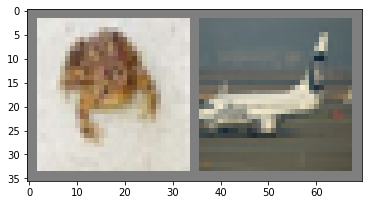

frog  plane


In [5]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#This is pyplot error solve code
#why this code have pyplot error? -> reason is 1. library crash 2. nomkl library not install 3. Too high numpy version

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

2. Define a Convolutional Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).


- 이미지가 RGB 3채널인것을 감안하며 신경망을 구성한다.
- 튜토리얼에서 구성한 신경망으로 살펴보아 기본적인 CNN 신경망으로 보인다.

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.

- 이제 학습을 진행하기 위해 손실함수와 파라미터 조정을 위한 옵티마이저를 설정한다.
- 손실 함수는 크로스엔트로피, 옵티마이저는 SGD로 학습률은 0.001, 관성은 0.9이다.)


In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.

- 이제 작성한 신경망을 학습시킨다.
- 아래의 코드의 경우 배치 단위만큼씩 진행하며 2회 반복 학습한다.

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.272
[1,  4000] loss: 2.020
[1,  6000] loss: 1.855
[1,  8000] loss: 1.720
[1, 10000] loss: 1.656
[1, 12000] loss: 1.612
[1, 14000] loss: 1.565
[1, 16000] loss: 1.543
[1, 18000] loss: 1.491
[1, 20000] loss: 1.470
[1, 22000] loss: 1.445
[1, 24000] loss: 1.430
[2,  2000] loss: 1.366
[2,  4000] loss: 1.348
[2,  6000] loss: 1.363
[2,  8000] loss: 1.344
[2, 10000] loss: 1.382
[2, 12000] loss: 1.320
[2, 14000] loss: 1.339
[2, 16000] loss: 1.333
[2, 18000] loss: 1.299
[2, 20000] loss: 1.301
[2, 22000] loss: 1.271
[2, 24000] loss: 1.295
Finished Training


Let's quickly save our trained model:

- 모델을 외부에 저장한다.

In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

See `here <https://pytorch.org/docs/stable/notes/serialization.html>`_
for more details on saving PyTorch models.

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

- 이제 신경망을 테스트할 시간이다.
- 이런 저런 말이 많지만 제대로 학습된 모델이 외부에 저장되었는지 확인해야한다는 내용이다.
- 외부에 저장한 모델 파일의 대한 자세한 내용은 위 링크에 있다.


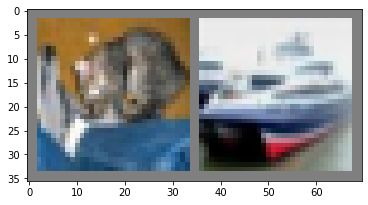

GroundTruth:  cat   ship 


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(2)))
# edit print repeat 4 to 2
# why?1. we edit batch_size in second code block. 
# why?2. Because I mistook the dead kernel error for a batch size problem, not pyplot.

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):

- 외부에 저장된 모델이 제대로 되어 있는 건지 확인 해본다.

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above are:

- 위 이미지를 예로 테스트 검증을 진행해본다.

In [14]:
outputs = net(images)

The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:

- 위의 lable 값과 마찬가지로 예측값이 도출되었다. 이로서 모델의 성능과 정상작동을 확인했다.

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(2)))

Predicted:  cat   ship 


The results seem pretty good.

Let us look at how the network performs on the whole dataset.

- 이제 전체 테스트 데이터에 대해 검증을 진행해본다.

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:

- 각 클래스별(분류별) 정확도를 알아보자.

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 55.9 %
Accuracy for class: car   is 91.2 %
Accuracy for class: bird  is 44.7 %
Accuracy for class: cat   is 52.6 %
Accuracy for class: deer  is 35.7 %
Accuracy for class: dog   is 42.0 %
Accuracy for class: frog  is 58.4 %
Accuracy for class: horse is 51.7 %
Accuracy for class: ship  is 65.9 %
Accuracy for class: truck is 32.5 %


Okay, so what next?

How do we run these neural networks on the GPU?

Training on GPU
----------------
Just like how you transfer a Tensor onto the GPU, you transfer the neural
net onto the GPU.

Let's first define our device as the first visible cuda device if we have
CUDA available:

- 우리는 이제 gpu를 사용해 모델을 학습하고 검증해볼 것이다.

In [76]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why don't I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_




### 새로운 모델을 구축하고 매개변수 최적화를 거쳐 정확도를 올려보자.

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
%matplotlib inline

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 2

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [26]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images.shape

torch.Size([2, 3, 32, 32])

In [82]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        #stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros)
        self.mpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.con1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.con2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((3, 3))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(192 * 3 * 3, 1920),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1920,10),
        )


    def forward(self, x):
        x = self.mpool(F.relu(self.con1(x)))
        x = self.mpool(F.relu(self.con2(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


net = Net()

In [83]:
net.to(device)

Net(
  (mpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (con2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1728, out_features=1920, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1920, out_features=10, bias=True)
  )
)

In [84]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.8)

In [85]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.070
[1,  4000] loss: 1.821
[1,  6000] loss: 1.693
[1,  8000] loss: 1.632
[1, 10000] loss: 1.577
[1, 12000] loss: 1.536
[1, 14000] loss: 1.500
[1, 16000] loss: 1.451
[1, 18000] loss: 1.426
[1, 20000] loss: 1.411
[1, 22000] loss: 1.380
[1, 24000] loss: 1.362
[2,  2000] loss: 1.295
[2,  4000] loss: 1.282
[2,  6000] loss: 1.277
[2,  8000] loss: 1.273
[2, 10000] loss: 1.276
[2, 12000] loss: 1.279
[2, 14000] loss: 1.234
[2, 16000] loss: 1.254
[2, 18000] loss: 1.218
[2, 20000] loss: 1.233
[2, 22000] loss: 1.211
[2, 24000] loss: 1.182
[3,  2000] loss: 1.148
[3,  4000] loss: 1.103
[3,  6000] loss: 1.154
[3,  8000] loss: 1.165
[3, 10000] loss: 1.107
[3, 12000] loss: 1.095
[3, 14000] loss: 1.134
[3, 16000] loss: 1.111
[3, 18000] loss: 1.118
[3, 20000] loss: 1.123
[3, 22000] loss: 1.106
[3, 24000] loss: 1.081
Finished Training


In [86]:
PATH = './cifar_net_gpu_custom.pth'
torch.save(net.state_dict(), PATH)

In [87]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [88]:
net.to(device)

Net(
  (mpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (con1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (con2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avgpool): AdaptiveAvgPool2d(output_size=(3, 3))
  (classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1728, out_features=1920, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1920, out_features=10, bias=True)
  )
)

In [89]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %
